# Surface water quality measurements
Emma Kok 

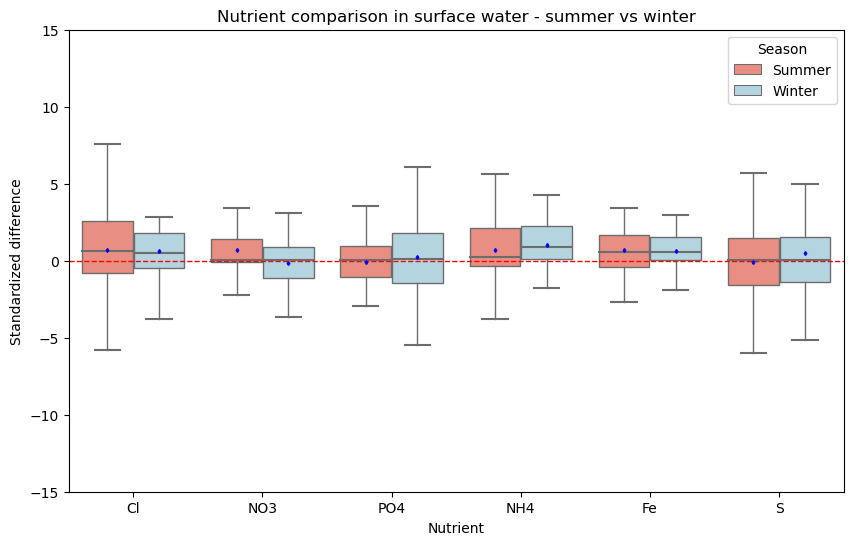

Normality test results for Cl:
  Summer MP data: p-value = 1.0, mean = 657.4300452764654
  Summer RP data: p-value = 1.0, mean = 670.014292670577
  Winter MP data: p-value = 0.003479091916233301, mean = 611.0452024217857
  Winter RP data: p-value = 1.0, mean = 715.6629309843137
Significance test results for Cl:
  Summer data: p-value = 0.8411575717206445
    No significant difference between summer MP and RP
  Winter data: p-value = 0.13765263379982765
    No significant difference between winter MP and RP

Normality test results for NO3:
  Summer MP data: p-value = 1.0, mean = 4.916018103448276
  Summer RP data: p-value = 1.0, mean = 1.8123759615384616
  Winter MP data: p-value = 1.2987481099249742e-12, mean = 17.267910714285712
  Winter RP data: p-value = 1.0, mean = 24.33786274509804
Significance test results for NO3:
  Summer data: p-value = 0.19297062067458814
    No significant difference between summer MP and RP
  Winter data: p-value = 0.22733645887726983
    No significant dif

In [2]:
# Import packages and open the data
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

NOBV_data = r"C:\Users\Kok30\OneDrive - Waternet Amsterdam\Documents\Analyse_NOBV2\Python_scripts\nat_vs_droog\NOBV_AlleData_B-Ware_WaterChemistry.txt"
df_NOBV = pd.read_csv(NOBV_data,sep='\t')
df_NOBV = df_NOBV.replace(',','.',regex=True)

# all values are floats, but python does not recognize it, so transfer it all
numeric_columns = ['PO4', 'P', 'NO3', 'NH4', 'S', 'Fe', 'Cl']
df_NOBV[numeric_columns] = df_NOBV[numeric_columns].astype(float)


# make python recognize the dates and set it as index (necessary to combine the data with rain)
df_NOBV['date'] = pd.to_datetime(df_NOBV['date'], format='%d-%m-%Y')
df_NOBV['date'] = df_NOBV['date'].dt.strftime('%d-%m-%y')
df_NOBV = df_NOBV.set_index('date')
    
# Define the locations to loop through, here you can set the different locations you want to check
locations = ['VLIST', 'ZEG', 'ROU', 'ASD', 'ALB'] # 'ZEG', 'ALB', 'ROU', 'ASD', 'VLIST'

# Create a function that makes a dataframe with the standardized differences 
def create_df(DF_MP, DF_RP, nutrient):
    DF_MP = DF_MP.reset_index(drop=True)
    DF_RP = DF_RP.reset_index(drop=True)
    
    # Use the index from DF_MP
    df = pd.DataFrame(index=DF_MP.index)  
    
    # drop the 
    df['meas'] = DF_MP[nutrient].dropna()
    df['ref'] = DF_RP[nutrient].dropna()

    df['difference'] = df['meas'] - df['ref']
    mean_difference = df['difference'].mean()
    df['standardized diff'] = df['difference'] / abs(mean_difference)
    
    df.sort_index(key=pd.to_datetime, inplace=True)
    return df, df['meas'], df['ref']


fig, ax = plt.subplots(figsize=(10, 6))
# Empty list to store the data for all locations
data = [] 

for location in locations:
    selected_location = df_NOBV[df_NOBV['location'] == location]

    # Separate summer and winter data
    summer_data = selected_location[(selected_location['month'] >= 5) & (selected_location['month'] <= 9)]
    winter_data = selected_location[(selected_location['month'] >= 10) | (selected_location['month'] <= 4)]

    # Seperate measurement plot and reference plot
    ow_sum_MP = summer_data[(summer_data['type'] == 'OW') & (summer_data['treatment'] =='OW_MP')]
    ow_wint_MP = winter_data[(winter_data['type'] == 'OW') & (winter_data['treatment'] == 'OW_MP')]
    ow_sum_RP = summer_data[(summer_data['type'] == 'OW') & (summer_data['treatment'] == 'OW_RP')]
    ow_wint_RP = winter_data[(winter_data['type'] == 'OW') & (winter_data['treatment'] == 'OW_RP')]


    # Summer data
    ow_data_sum = {}
    for nutrient in ['Cl', 'NO3', 'PO4', 'NH4', 'Fe', 'S']:
        ow_data_sum[f"{nutrient}"], ow_data_sum_meas, ow_data_sum_ref = create_df(ow_sum_MP, ow_sum_RP, nutrient)

    # Winter data
    ow_data_wint = {}
    for nutrient in ['Cl', 'NO3','PO4', 'NH4', 'Fe', 'S']:
        ow_data_wint[f"{nutrient}"], ow_data_wint_meas, ow_data_wint_ref = create_df(ow_wint_MP, ow_wint_RP, nutrient)

    # Prepare the data for each nutrient, separating the values for summer and winter
    summer_data = pd.DataFrame({'Nutrient': ['Cl'] * len(ow_data_sum['Cl']['standardized diff']),
                                'Data': ow_data_sum['Cl']['standardized diff'],
                                'Season': 'Summer',
                                'Meas': ow_data_sum_meas,
                                'Ref': ow_data_sum_ref})

    winter_data = pd.DataFrame({'Nutrient': ['Cl'] * len(ow_data_wint['Cl']['standardized diff']),
                                'Data': ow_data_wint['Cl']['standardized diff'],
                                'Season': 'Winter',
                                'Meas': ow_data_wint_meas,
                                'Ref': ow_data_wint_ref})


    for nutrient in ['NO3', 'PO4', 'NH4', 'Fe', 'S']:
        summer_data = pd.concat([summer_data, pd.DataFrame({'Nutrient': [nutrient] * len(ow_data_sum[nutrient]['standardized diff']),
                                                            'Data': ow_data_sum[nutrient]['standardized diff'],
                                                            'Season': 'Summer',
                                                            'Meas': ow_data_sum[nutrient]['meas'],
                                                            'Ref': ow_data_sum[nutrient]['ref']})])
        winter_data = pd.concat([winter_data, pd.DataFrame({'Nutrient': [nutrient] * len(ow_data_wint[nutrient]['standardized diff']),
                                                            'Data': ow_data_wint[nutrient]['standardized diff'],
                                                            'Season': 'Winter',
                                                            'Meas': ow_data_wint[nutrient]['meas'],
                                                            'Ref': ow_data_wint[nutrient]['ref']})])


    # Concatenate summer and winter data
    location_data = pd.concat([summer_data, winter_data])
    location_data['Location'] = location  # Add a column for location

    data.append(location_data)  # Add location data to the list

# Combine data for all locations
all_data = pd.concat(data)
custom_palette = {"Summer": "salmon", "Winter": "lightblue"}

sns.boxplot(x='Nutrient', y='Data', hue='Season', palette=custom_palette, data=all_data, ax=ax, showmeans=True,
            boxprops=dict(linewidth=1),
            whiskerprops=dict(linewidth=1),
            showfliers=False,
            flierprops=dict(marker='o', markerfacecolor='black', markersize=2),
            meanprops=dict(marker='d', markerfacecolor='blue', markeredgecolor='blue', markersize=2))  # Updated marker properties

ax.axhline(y=0, color='red', linestyle='--', linewidth=1)
ax.set_title('Nutrient comparison in surface water - summer vs winter')
ax.set_xlabel('Nutrient')
ax.set_ylabel('Standardized difference')
ax.set_ylim(-15,15)

plt.savefig("ow_all_26_6.pdf")
plt.show()

# Loop through nutrients for statistical analysis
for nutrient in ['Cl', 'NO3', 'NH4', 'Fe', 'PO4', 'S']:
    # Extract summer and winter data for the nutrient, separated by measurement plot (MP) and reference plot (RP)
    summer_MP_data = all_data[(all_data['Season'] == 'Summer') & (all_data['Nutrient'] == nutrient)]['Meas']
    summer_RP_data = all_data[(all_data['Season'] == 'Summer') & (all_data['Nutrient'] == nutrient)]['Ref']
    winter_MP_data = all_data[(all_data['Season'] == 'Winter') & (all_data['Nutrient'] == nutrient)]['Meas']
    winter_RP_data = all_data[(all_data['Season'] == 'Winter') & (all_data['Nutrient'] == nutrient)]['Ref']
    
    # Test normality
    _, summer_MP_p_value = stats.shapiro(summer_MP_data)
    _, summer_RP_p_value = stats.shapiro(summer_RP_data)
    _, winter_MP_p_value = stats.shapiro(winter_MP_data)
    _, winter_RP_p_value = stats.shapiro(winter_RP_data)
    
    # Print normality test results
    print(f"Normality test results for {nutrient}:")
    print(f"  Summer MP data: p-value = {summer_MP_p_value}, mean = {summer_MP_data.mean()}")
    print(f"  Summer RP data: p-value = {summer_RP_p_value}, mean = {summer_RP_data.mean()}")
    print(f"  Winter MP data: p-value = {winter_MP_p_value}, mean = {winter_MP_data.mean()}")
    print(f"  Winter RP data: p-value = {winter_RP_p_value}, mean = {winter_RP_data.mean()}")


    # Perform appropriate statistical tests based on normality
    if summer_MP_p_value > 0.05 and summer_RP_p_value > 0.05:
        # If both summer MP and RP data are normally distributed, use paired t-test
        _, summer_p_value = stats.ttest_rel(summer_MP_data.fillna(summer_MP_data.mean()), summer_RP_data.fillna(summer_RP_data.mean()))
    else:
        # If either summer MP or RP data is not normally distributed, use Wilcoxon signed-rank test
        _, summer_p_value = stats.wilcoxon(summer_MP_data.fillna(summer_MP_data.mean()), summer_RP_data.fillna(summer_RP_data.mean()))


    if winter_MP_p_value > 0.05 and winter_RP_p_value > 0.05:
        # If both winter MP and RP data are normally distributed, use paired t-test
        _, winter_p_value = stats.ttest_rel(winter_MP_data.fillna(winter_MP_data.mean()), winter_RP_data.fillna(winter_RP_data.mean()))
    else:
        # If either winter MP or RP data is not normally distributed, use Wilcoxon signed-rank test
        _, winter_p_value = stats.wilcoxon(winter_MP_data.fillna(winter_MP_data.mean()), winter_RP_data.fillna(winter_RP_data.mean()))

    
    # Print test results
    print(f"Significance test results for {nutrient}:")
    print(f"  Summer data: p-value = {summer_p_value}")
    if not pd.isna(summer_p_value) and summer_p_value < 0.05:
        print("    Significant difference between summer MP and RP")
    else:
        print("    No significant difference between summer MP and RP")
    
    print(f"  Winter data: p-value = {winter_p_value}")
    if not pd.isna(winter_p_value) and winter_p_value < 0.05:
        print("    Significant difference between winter MP and RP")
    else:
        print("    No significant difference between winter MP and RP")
    
    print()



# The rest of the script contains information for future research, by splitting the years and looking at the differences in years. Not to be graded for this thesis.

# Comparison different years

Paired t-test for nutrient Cl:
t-statistic: 1.5654922490861474
p-value: 0.13978553870481872
The difference is not statistically significant.

Paired t-test for nutrient NO3:
t-statistic: 0.051426065330513276
p-value: 0.9597125660420731
The difference is not statistically significant.

Paired t-test for nutrient NH4:
t-statistic: 3.4287487970671275
p-value: 0.004073192571180969
The difference is statistically significant.

Paired t-test for nutrient Fe:
t-statistic: 3.014253718229933
p-value: 0.0092853928846187
The difference is statistically significant.

Paired t-test for nutrient PO4:
t-statistic: 0.5308431972651902
p-value: 0.6038472120434827
The difference is not statistically significant.

Paired t-test for nutrient S:
t-statistic: -2.1624960423513016
p-value: 0.04837690328907521
The difference is statistically significant.

Paired t-test for nutrient Cl:
t-statistic: nan
p-value: nan
The difference is not statistically significant.

Paired t-test for nutrient NO3:
t-statistic: na

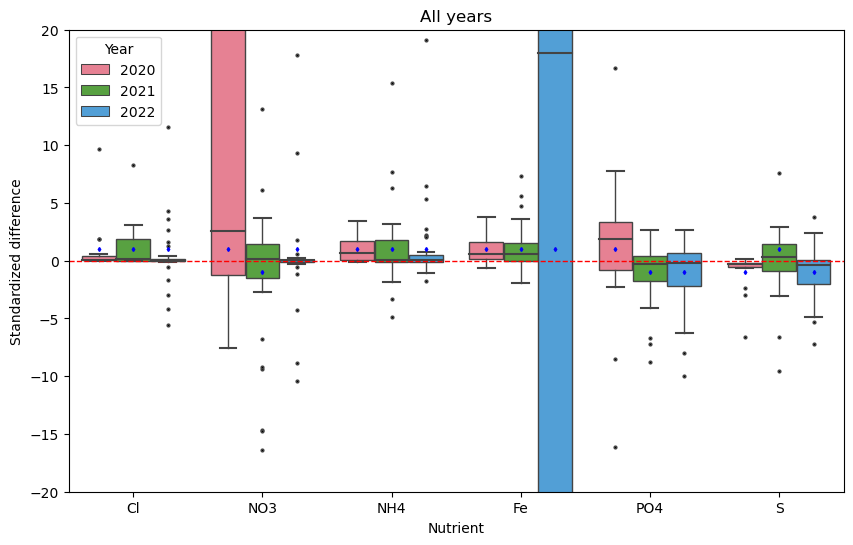

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.stats as stats

def create_df(DF_MP, DF_RP, nutrient, ow_data):
    DF_MP[nutrient] = DF_MP[nutrient].groupby(DF_MP[nutrient].index).mean().sort_index(key=pd.to_datetime)
    DF_RP[nutrient] = DF_RP[nutrient].groupby(DF_RP[nutrient].index).mean().sort_index(key=pd.to_datetime)

    df = pd.DataFrame(index=DF_MP[nutrient].index.unique())
    df[(nutrient, 'meas')] = DF_MP[nutrient].groupby(DF_MP[nutrient].index).mean().sort_index(key=pd.to_datetime)
    df[(nutrient, 'ref')] = DF_RP[nutrient].groupby(DF_RP[nutrient].index).mean().sort_index(key=pd.to_datetime)
    
    df['difference'] = df[(nutrient, 'meas')] - df[(nutrient, 'ref')] 
    mean_difference = df['difference'].mean()

    df['standardized diff'] = df['difference'] / abs(mean_difference)

        
    # Perform paired t-test
    t_stat, p_value = stats.ttest_rel(df[(nutrient, 'meas')], df[(nutrient, 'ref')])

    print(f"Paired t-test for nutrient {nutrient}:")
    print(f"t-statistic: {t_stat}")
    print(f"p-value: {p_value}")
    if p_value < 0.05:
        print("The difference is statistically significant.")
    else:
        print("The difference is not statistically significant.")
    print()
    
    return df


# Define the years to compare
years = [2020, 2021, 2022]

fig, ax = plt.subplots(figsize=(10, 6))

data = []  # Empty list to store the data for all years

for year in years:
    selected_year = df_NOBV[df_NOBV['year'] == year]

    # Separate measurement perceel and reference perceel
    ow_MP = selected_year[(selected_year['type'] == 'OW') & (selected_year['treatment'] =='OW_MP')]
    ow_RP = selected_year[(selected_year['type'] == 'OW') & (selected_year['treatment'] == 'OW_RP')]

    # Prepare the data for each nutrient
    ow_data = {}
    for nutrient in ['Cl', 'NO3', 'NH4', 'Fe', 'PO4', 'S']:
        ow_data[f"{nutrient}"] = create_df(ow_MP, ow_RP, nutrient, ow_data)

    # Concatenate data for each nutrient
    year_data = pd.concat([pd.DataFrame({'Nutrient': [nutrient] * len(ow_data[nutrient]['standardized diff']),
                                         'Data': ow_data[nutrient]['standardized diff'],
                                         'Year': year}) for nutrient in ['Cl', 'NO3', 'NH4', 'Fe', 'PO4', 'S']])

    data.append(year_data)  # Add year data to the list

# Combine data for all years
all_data = pd.concat(data)
custom_palette = {year: sns.color_palette("husl", len(years))[i] for i, year in enumerate(years)}

sns.boxplot(x='Nutrient', y='Data', hue='Year', palette=custom_palette, data=all_data, ax=ax, showmeans=True,
            boxprops=dict(linewidth=1),
            whiskerprops=dict(linewidth=1),
            flierprops=dict(marker='o', markerfacecolor='black', markersize=2),
            meanprops=dict(marker='d', markerfacecolor='blue', markeredgecolor='blue', markersize=2))  # Updated marker properties

ax.axhline(y=0, color='red', linestyle='--', linewidth=1)
ax.set_title('All years')
ax.set_xlabel('Nutrient')
ax.set_ylabel('Standardized difference')
ax.set_ylim(-20, 20)

plt.savefig("OW_years.pdf")
plt.show()


This code will calculate the t-statistic and the p-value for the paired t-test between the Cl, meas and Cl, ref values for each nutrient. The stats.ttest_rel() function performs the paired t-test, assuming that the Cl, meas and Cl, ref values come from the same samples but under different conditions (measured and reference). The t_stat variable will contain the calculated t-statistic, and the p_value variable will contain the corresponding p-value.

You can add this code after the create_df() function in your existing code. Iterate over the desired nutrients and calculate the t-test statistics and p-values. This will allow you to test the significance of the differences between the Cl, meas and Cl, ref values for each nutrient.

Paired t-test for nutrient Cl in year 2020:
t-statistic: 1.5654922490861474
p-value: 0.13978553870481872
The difference is not statistically significant.

Paired t-test for nutrient NO3 in year 2020:
t-statistic: 0.051426065330513276
p-value: 0.9597125660420731
The difference is not statistically significant.

Paired t-test for nutrient NH4 in year 2020:
t-statistic: 3.4287487970671275
p-value: 0.004073192571180969
The difference is statistically significant.

Paired t-test for nutrient Fe in year 2020:
t-statistic: 3.014253718229933
p-value: 0.0092853928846187
The difference is statistically significant.

Paired t-test for nutrient PO4 in year 2020:
t-statistic: 0.5308431972651902
p-value: 0.6038472120434827
The difference is not statistically significant.

Paired t-test for nutrient S in year 2020:
t-statistic: -2.1624960423513016
p-value: 0.04837690328907521
The difference is statistically significant.

Paired t-test for nutrient Cl in year 2021:
t-statistic: 3.5848702458291637
p-va

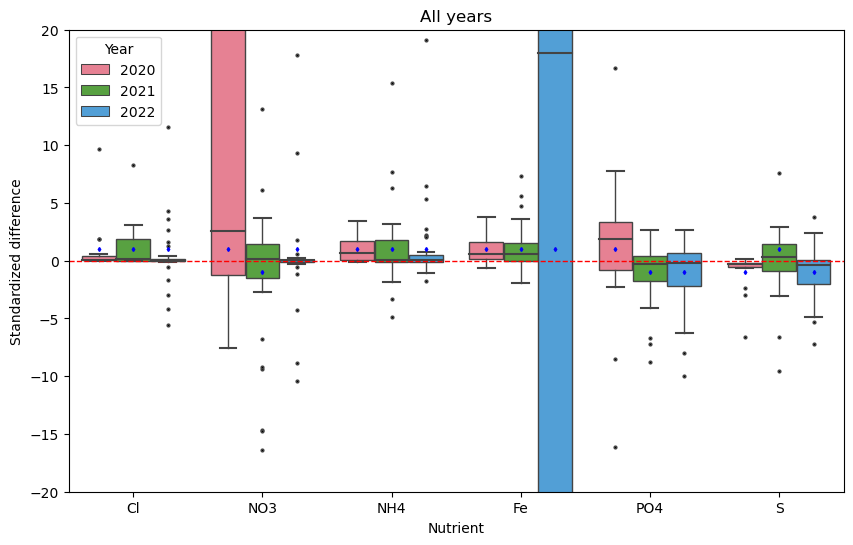

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.stats as stats

def create_df(DF_MP, DF_RP, nutrient, ow_data, year):
    DF_MP[nutrient] = DF_MP[nutrient].groupby(DF_MP[nutrient].index).mean().sort_index(key=pd.to_datetime)
    DF_RP[nutrient] = DF_RP[nutrient].groupby(DF_RP[nutrient].index).mean().sort_index(key=pd.to_datetime)

    df = pd.DataFrame(index=DF_MP[nutrient].index.unique())
    df[(nutrient, 'meas')] = DF_MP[nutrient].groupby(DF_MP[nutrient].index).mean().sort_index(key=pd.to_datetime)
    df[(nutrient, 'ref')] = DF_RP[nutrient].groupby(DF_RP[nutrient].index).mean().sort_index(key=pd.to_datetime)
    
    df['difference'] = df[(nutrient, 'meas')] - df[(nutrient, 'ref')] 
    mean_difference = df['difference'].mean()

    df['standardized diff'] = df['difference'] / abs(mean_difference)

    #     # Shapiro-Wilk test for normality
    #     for col in [(nutrient, 'meas'), (nutrient, 'ref')]:
    #         shapiro_stat, shapiro_p = stats.shapiro(df[col])
    #         print(f"Normality test for column {col}:")
    #         print(f"Shapiro-Wilk statistic: {shapiro_stat}")
    #         print(f"p-value: {shapiro_p}")
    #         if shapiro_p < 0.05:
    #             print("The data is not normally distributed.")
    #         else:
    #             print("The data is normally distributed.")
    #         print()
    # Perform paired t-test
    t_stat, p_value = stats.ttest_rel(df[(nutrient, 'meas')], df[(nutrient, 'ref')], nan_policy='omit')

    print(f"Paired t-test for nutrient {nutrient} in year {year}:")
    print(f"t-statistic: {t_stat}")
    print(f"p-value: {p_value}")
    if p_value < 0.05:
        print("The difference is statistically significant.")
    else:
        print("The difference is not statistically significant.")
    print()
    
    return df


# Define the years to compare
years = [2020, 2021, 2022]

fig, ax = plt.subplots(figsize=(10, 6))

data = []  # Empty list to store the data for all years

for year in years:
    selected_year = df_NOBV[df_NOBV['year'] == year]

    # Separate measurement perceel and reference perceel
    ow_MP = selected_year[(selected_year['type'] == 'OW') & (selected_year['treatment'] =='OW_MP')]
    ow_RP = selected_year[(selected_year['type'] == 'OW') & (selected_year['treatment'] == 'OW_RP')]

    # Prepare the data for each nutrient
    ow_data = {}
    for nutrient in ['Cl', 'NO3', 'NH4', 'Fe', 'PO4', 'S']:
        ow_data[f"{nutrient}"] = create_df(ow_MP, ow_RP, nutrient, ow_data, year)

    # Concatenate data for each nutrient
    year_data = pd.concat([pd.DataFrame({'Nutrient': [nutrient] * len(ow_data[nutrient]['standardized diff']),
                                         'Data': ow_data[nutrient]['standardized diff'],
                                         'Year': year}) for nutrient in ['Cl', 'NO3', 'NH4', 'Fe', 'PO4', 'S']])

    data.append(year_data)  # Add year data to the list

# Combine data for all years
all_data = pd.concat(data)
custom_palette = {year: sns.color_palette("husl", len(years))[i] for i, year in enumerate(years)}

sns.boxplot(x='Nutrient', y='Data', hue='Year', palette=custom_palette, data=all_data, ax=ax, showmeans=True,
            boxprops=dict(linewidth=1),
            whiskerprops=dict(linewidth=1),
            flierprops=dict(marker='o', markerfacecolor='black', markersize=2),
            meanprops=dict(marker='d', markerfacecolor='blue', markeredgecolor='blue', markersize=2))  # Updated marker properties

ax.axhline(y=0, color='red', linestyle='--', linewidth=1)
ax.set_title('All years')
ax.set_xlabel('Nutrient')
ax.set_ylabel('Standardized difference')
ax.set_ylim(-20, 20)

#plt.savefig("OW_years.pdf")
plt.show()


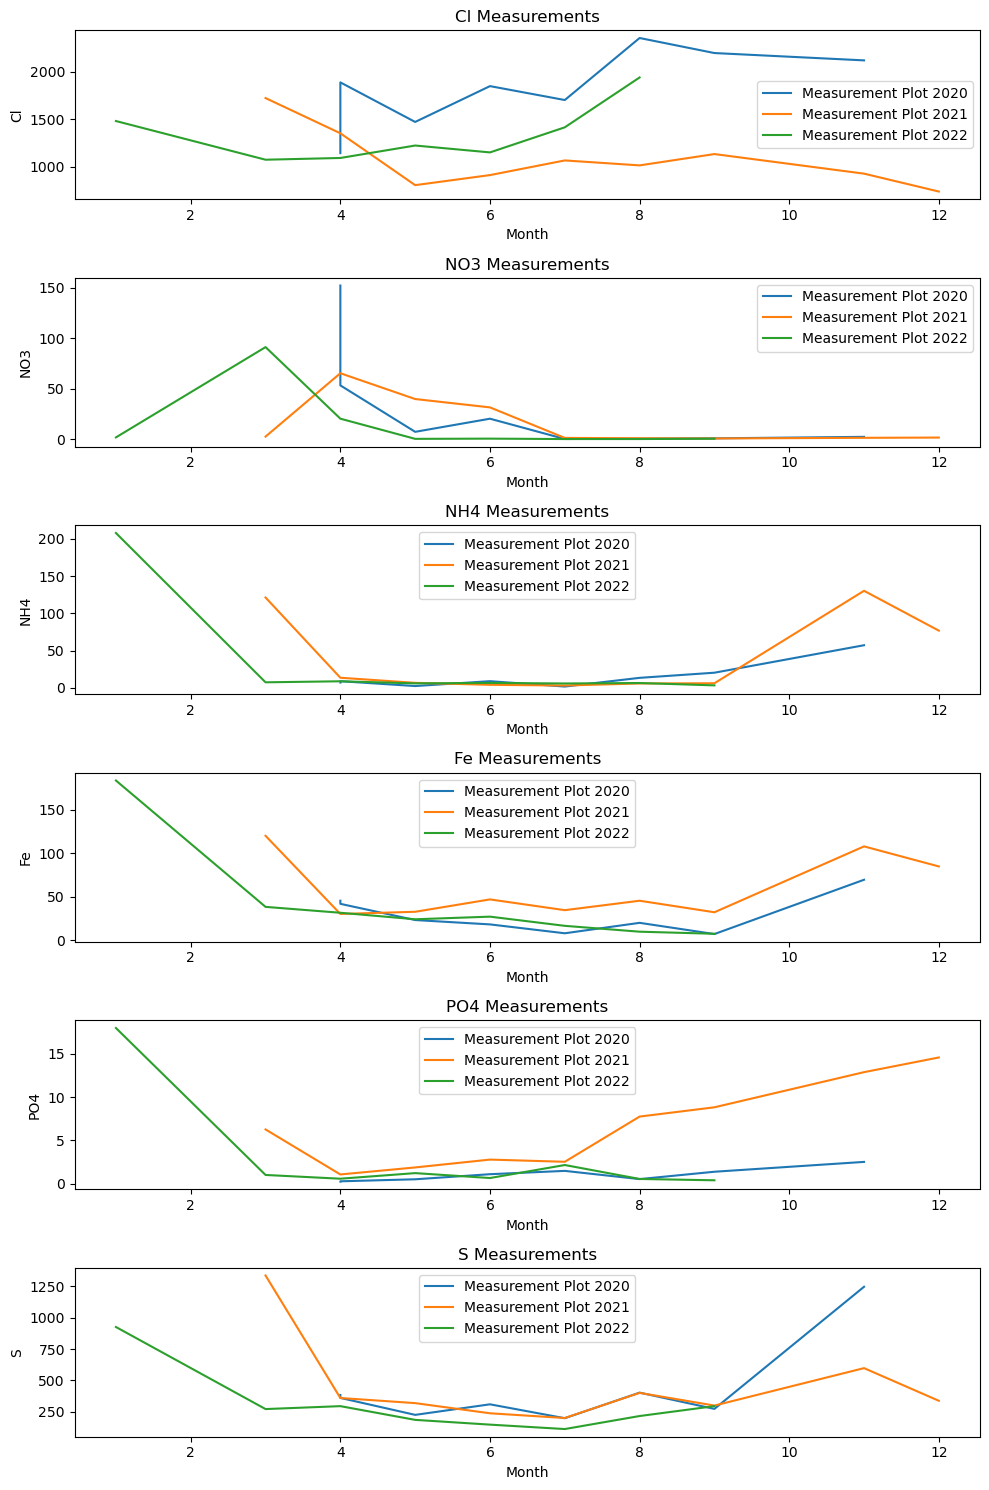

In [12]:
# Open data
NOBV_data = r"C:\Users\Kok30\OneDrive - Waternet Amsterdam\Documents\Analyse_NOBV2\Python_scripts\nat_vs_droog\NOBV_AlleData_B-Ware_WaterChemistry.txt"
df_NOBV = pd.read_csv(NOBV_data, sep='\t')
df_NOBV = df_NOBV.replace(',', '.', regex=True)

# Convert columns to floats
float_columns = ['PO4', 'P', 'NO3', 'NH4', 'S', 'Fe', 'Cl']
df_NOBV[float_columns] = df_NOBV[float_columns].astype(float)

# Convert dates and set index
df_NOBV['date'] = pd.to_datetime(df_NOBV['date'], format='%d-%m-%Y')
df_NOBV['month'] = df_NOBV['date'].dt.month  # Extract month
df_NOBV = df_NOBV.set_index('date')

selected_location = df_NOBV[df_NOBV['location'] == 'ALB']

years = [2020, 2021, 2022]
nutrients = ['Cl', 'NO3', 'NH4', 'Fe', 'PO4', 'S']

fig, axes = plt.subplots(len(nutrients), 1, figsize=(10, 15))

for i, nutrient in enumerate(nutrients):
    ax = axes[i]
    for year in years:
        year_data = selected_location[(selected_location.index.year == year)]  # Filter by year
        year_mp = year_data[(year_data['type'] == 'OW') & (year_data['treatment'] == 'OW_MP')]
        year_rp = year_data[(year_data['type'] == 'OW') & (year_data['treatment'] == 'OW_RP')]

        ax.plot(year_mp['month'], year_mp[nutrient], label=f'Measurement Plot {year}')
        #ax.plot(year_rp['month'], year_rp[nutrient], label=f'Reference Plot {year}', linestyle='--')

    ax.set_xlabel('Month')
    ax.set_ylabel(nutrient)
    ax.set_title(f'{nutrient} Measurements')
    ax.legend()

plt.tight_layout()
plt.show()

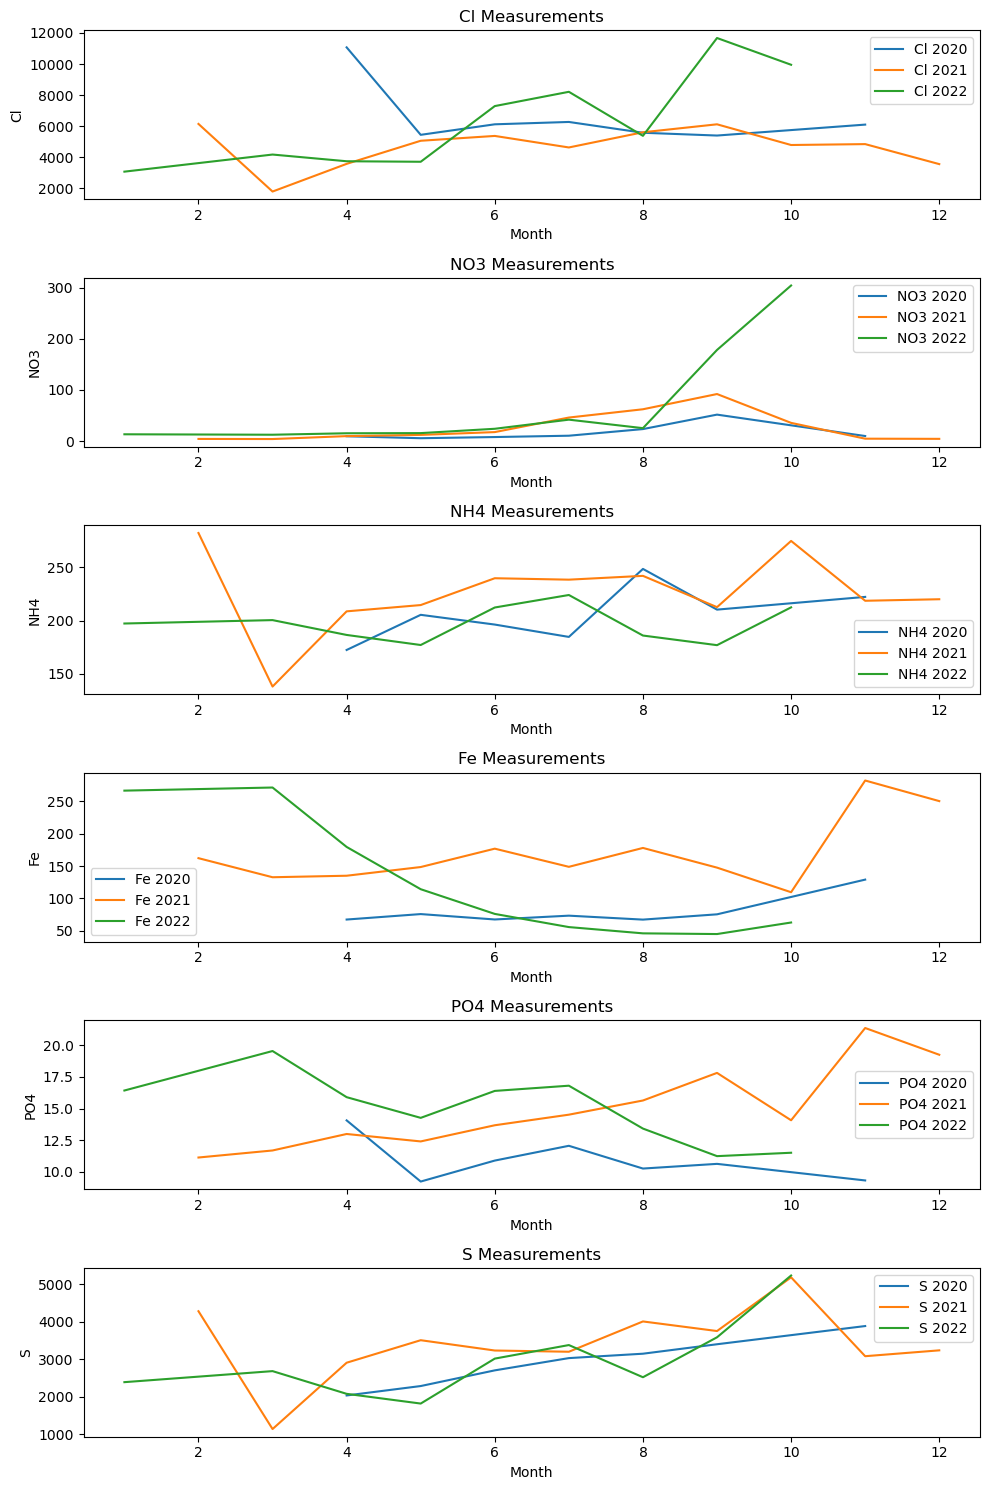

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Open data
NOBV_data = r"C:\Users\Kok30\OneDrive - Waternet Amsterdam\Documents\Analyse_NOBV2\Python_scripts\nat_vs_droog\NOBV_AlleData_B-Ware_WaterChemistry.txt"
df_NOBV = pd.read_csv(NOBV_data, sep='\t')
df_NOBV = df_NOBV.replace(',', '.', regex=True)

# Convert columns to floats
float_columns = ['PO4', 'P', 'NO3', 'NH4', 'S', 'Fe', 'Cl']
df_NOBV[float_columns] = df_NOBV[float_columns].astype(float)

# Convert dates and set index
df_NOBV['date'] = pd.to_datetime(df_NOBV['date'], format='%d-%m-%Y')
df_NOBV['month'] = df_NOBV['date'].dt.month  # Extract month
df_NOBV = df_NOBV.set_index('date')

selected_locations = df_NOBV[df_NOBV['location'].isin(['ALB', 'ZEG', 'ASD', 'VLIST', 'ROU'])]

years = [2020, 2021, 2022]
nutrients = ['Cl', 'NO3', 'NH4', 'Fe', 'PO4', 'S']

fig, axes = plt.subplots(len(nutrients), 1, figsize=(10,15))

for i, nutrient in enumerate(nutrients):
    ax = axes[i]
    for year in years:
        year_data = selected_locations[(selected_locations.index.year == year)]  # Filter by year

        # Combine data from all locations for the nutrient and year
        combined_data = year_data.groupby('month')[nutrient].mean()

        ax.plot(combined_data.index, combined_data.values, label=f'{nutrient} {year}')

    ax.set_xlabel('Month')
    ax.set_ylabel(nutrient)
    ax.set_title(f'{nutrient} Measurements')
    ax.legend()

plt.tight_layout()
plt.show()


In [ ]:
from scipy.stats import ttest_1samp

# Perform t-test for each nutrient in summer and winter
for nutrient in ['Cl', 'NO3', 'NH4', 'Fe', 'PO4', 'S']:
    summer_data = all_data[(all_data['Nutrient'] == nutrient) & (all_data['Season'] == 'Summer')]['Data']
    winter_data = all_data[(all_data['Nutrient'] == nutrient) & (all_data['Season'] == 'Winter')]['Data']

    # Remove rows with missing values
    summer_data = summer_data.dropna()
    winter_data = winter_data.dropna()

    summer_mean = summer_data.mean()
    winter_mean = winter_data.mean()

    # Perform t-test if data is available
    if len(summer_data) > 0 and len(winter_data) > 0:
        t_stat, p_value = ttest_1samp(summer_data, 0)
    else:
        t_stat, p_value = float('nan'), float('nan')

    print(f"Nutrient: {nutrient}")
    print(f"Summer Mean: {summer_mean:.2f}")
    print(f"Winter Mean: {winter_mean:.2f}")
    print(f"T-statistic: {t_stat:.2f}")
    print(f"P-value: {p_value:.4f}")
    print()
